In [3]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install seaborn

## Configuración:
* Importación Librerias
* Definición rutas
* Definición funciones auxiliares

In [4]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2

from modules.gnn_models import GCN, GraphSAGE, GAT
from modules.graph import Graph
from modules.gnn import GNN
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import numpy as np

# from modules.gnn import GNN
# from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
# from modules.predictors import DotPredictor, MLPPredictor, MLPPredictorEmbeddings
# from modules.graph_from_api import Graph_API
# from dgl.sampling import pack_traces

# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.optim import SparseAdam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import (
    confusion_matrix,              # ya lo estabas usando
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)
# from utils import *
# from modules.graph import Graph
# import numpy as np
import os
# import fnmatch
# import tqdm
# import networkx as nx

# import dgl.function as fn
# from dgl.nn import DeepWalk
# from torch.utils.data import DataLoader

# from sklearn.linear_model import LogisticRegression
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from bgp2vec.bgp2vec import BGP2VEC
from utils import month_name_to_number, month_number_to_name

print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Versión de DGL: 2.5.0+cu121
Versión de PyTorch: 2.3.0+cu121


In [5]:
# Fecha 
MES = "febrero"
ANO = "2024"

Primero se de debe correr notebook create_as_attr.ipynb el cual crea el archivo  node_feature_{MES}_{ANO}.csv"
correspondientet a los atributos de los nodos de una fecha especifica a partir de la informacion recolectada de PeeringDB para es afecha

In [6]:
# Path proyecto base
BASE_PROJECT_PATH = os.getcwd() + "/data/"

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# Ruta archivo CAIDA AS Relationships
RELATIONSHIPS_FILE  = DATA_PATH + f"CAIDA_AS_Relationships/Serial_1/{ANO}{month_name_to_number(MES)}01.as-rel.txt.bz2"

# Ruta archivo features de nodos (creadas a partir de PeeringDB en archivo create_as_attr.ipynb) 
FEATURES_FILE = DATA_PATH + f"node_features_{MES}_{ANO}.csv" #"/node_features.csv" 

# Ruta archivo RIB sanitizado
RIB_FILE = DATA_PATH + f'RIBs/sanitized_rib_{MES}_{ANO}.txt'

# Ruta donde se guardaran los grafo DGL
OUTPUT_DIR = DATA_PATH +  f'dgl_graph/{MES}_{ANO}/'

# MAximo numero de rutas a procesar del RIB para crear grafo
MAX_NUM_ROUTES = 1000000 # None

### Funciones Auxiliares plot

In [ ]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Matriz de confusión',
                          fname=None,
                          cmap=plt.cm.Blues,
                          save=False):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    
    if save and fname is not None:
        plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_2(cm,
                            classes,
                            normalize=False,
                            title='Matriz de confusión',
                            fname=None,
                            cmap=plt.cm.Blues,
                            save=False):
    """
    Dibuja la matriz de confusión.
    Si `normalize=True`, muestra los valores en **porcentaje (%)**.
    """
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # → %
        print("Matriz de confusión normalizada (%)")
        fmt  = ".1f"   # un decimal
        suffix = "%"   # añade símbolo %
    else:
        print("Matriz de confusión sin normalizar")
        fmt  = "d"
        suffix = ""

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i,
                     f"{format(cm[i, j], fmt)}{suffix}",
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Etiqueta real")
    plt.xlabel("Etiqueta predicha")
    plt.tight_layout()

    # if save and fname:
        # plt.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    plt.show()

## Creacion Grafo 

Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream.

In [10]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt

/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt*


In [29]:
from modules.graph import create_graphs_from_ribs
# CASO 0: Grafo con atributos de nodos extraídos de PeeringDB
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "peeringdb")

# CASO 1,2,3: Grafo con atributos de grado de entrada y salida 
# graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "degree")

# CASO 4: Grafo con atributos de nodos generados aleatoriamente 
# graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "random")

[ARCHIVO META CREADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024//meta.yaml
[ARCHIVO GRAPHS.CSV CREADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024//graphs.csv
[ELIMINADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/edges.csv
[ELIMINADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/nodes.csv

[CREANDO GRAFO MES]: enero---------------------------------
[SI EXISTE]
numero: 1
graph_id: 1
[NX GRAPH]: DiGraph with 41423 nodes and 148905 edges
[SAVE IN]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/edges.csv
[AGREGANDO TODAS FEATURES A NODOS DESDE PEERINGDB]
Creando archivo: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/nodes.csv


FileNotFoundError: [Errno 2] No such file or directory: '/media/valentina/KINGSTON/TESIS/data/node_features_enero_2024_01.csv'

## Entrenamiento

In [ ]:

# DATA_PATH = '/media/valentina/KINGSTON/TESIS'
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
# rib_path = '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

# # Grafo Internet con Grado
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/nternetGraphs2024Degree/'

# # Grafo Internet con datos 2022
# INTERNETGRAPH_FILE ='/media/valentina/KINGSTON/TESIS/InternetGNNData2022/'

# Grafo Internet con PeeringDB
# INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024'

# Grafo Internet con PeeringDB completo de febrero
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

# Grafo Internet con PeeringDB completo de octubre 2025
INTERNETGRAPH_FILE = DATA_PATH + '/dgl_graph/octubre_2025/'

# Grafo Internet de febrero 2024
INTERNETGRAPH_FILE = DATA_PATH + '/dgl_graph/2024/'



In [9]:
# Importación Grafo ya creado

gnn = GNN(debug=True)
gnn.load_dataset(
    data_path= INTERNETGRAPH_FILE,
    index_graph=1,            # grafo de febrero
    caida_path=RELATIONSHIPS_FILE,
    simplify=True, 
)

[load_dataset] Leyendo CSV …
Done saving data into cached files.


IndexError: list index out of range

### Caso 0: Se utiliza grafo con atributos de nodos extraídos de PeeringDB 

#### Caso 0.0: No Leaky split

In [6]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [ ]:


# Comprobar cantidad aristas con y sin etiqueta
from collections import Counter

print('[GRAFO]',gnn.dgl_graph)

rel = gnn.dgl_graph.edata['Relationship']
print("Etiquetas:", (rel >= 0).sum().item(), "con etiqueta  |",
                    (rel < 0).sum().item(),  "sin etiqueta")

print("Etiquetas:", Counter(rel.tolist()))



In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240101.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/full'

gnn = GNN(debug=True)
mes = 'enero'
# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 0,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.8, seed=42)

# 2 min

##### Encoder : decodeBilinear

In [ ]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score
)
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 200
lr            = 0.02
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()

        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))










# ─── métricas micro / macro / weighted y accuracy (en %) ─────────
    prec_micro = precision_score(truth, preds_best, average="micro") * 100
    rec_micro  = recall_score(truth, preds_best, average="micro") * 100
    f1_micro   = f1_score(truth, preds_best, average="micro") * 100
    acc        = accuracy_score(truth, preds_best) * 100

    prec_macro = precision_score(truth, preds_best, average="macro") * 100
    rec_macro  = recall_score(truth, preds_best, average="macro") * 100
    f1_macro   = f1_score(truth, preds_best, average="macro") * 100

    prec_w     = precision_score(truth, preds_best, average="weighted") * 100
    rec_w      = recall_score(truth, preds_best, average="weighted") * 100
    f1_w       = f1_score(truth, preds_best, average="weighted") * 100

    print(f"[TEST] micro:    Prec={prec_micro:.2f}%  Rec={rec_micro:.2f}%  F1={f1_micro:.2f}% | Acc={acc:.2f}%")
    print(f"[TEST] macro:    Prec={prec_macro:.2f}%  Rec={rec_macro:.2f}%  F1={f1_macro:.2f}%")
    print(f"[TEST] weighted: Prec={prec_w:.2f}%  Rec={rec_w:.2f}%  F1={f1_w:.2f}%")




















    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.savefig( '/media/valentina/KINGSTON/TESIS/resultados/graficos/end-to-end/' + f"loss_{name}_caso0_mis_attr.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.savefig( '/media/valentina/KINGSTON/TESIS/resultados/graficos/end-to-end/' + f"accuracy_{name}_caso0_mis_attr.png", dpi=300, bbox_inches='tight')
    plt.show()


    out_file = f"/media/valentina/KINGSTON/TESIS/resultados/inferencias_gnn/end_to_end/inference_results_{name}_{mes}_caso0_mis_attr.txt"
    u, v = g.edges()
    with open(out_file, "w") as f:
        for i, eidx in enumerate(torch.nonzero(test_m, as_tuple=False).squeeze().cpu().numpy()):
            as1 = int(u[eidx].item())
            as2 = int(v[eidx].item())
            pred = int(preds_best[i].item())
            real = int(truth[i].item())
            f.write(f"{as1}|{as2}|{pred}|{real}\n")

    print(f"Archivo {out_file} guardado correctamente.")


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")




Viendo estos resultados igual me hace pensar que hay algun information leak , por el garfico de loss y accuracy que tenemos ya que el test y y validacion son muy iguales y no suce de un sobreajuste donde se van deferiendo los puntajes despues de cierto punto.

Ademas si corremos esto en 50 epoch en muhco mas malo que en 100 epochs .... OBSERVAR


In [ ]:
best_loss = float('inf')
best_ep   = 0
best_w    = None           # se llenará con los pesos óptimos

for epoch in range(1, epochs + 1):
    # ----- train -----
    model.train()
    h      = model.encode(g, feat)
    logits = model.decodeBilinear(g, h)
    loss   = F.cross_entropy(logits[train_m], labels[train_m])

    opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        preds_tr = logits[train_m].argmax(1)
        acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

    # ----- test -----
    model.eval()
    with torch.no_grad():
        logits_te = model.decodeBilinear(g, model.encode(g, feat))
        loss_te   = F.cross_entropy(logits_te[test_m], labels[test_m])
        preds_te  = logits_te[test_m].argmax(1)
        acc_te    = (preds_te == labels[test_m]).float().mean().item()

    # ----- almacenar histórico -----
    history["loss_tr"].append(loss.item())
    history["loss_te"].append(loss_te.item())
    history["acc_tr"].append(acc_tr * 100)
    history["acc_te"].append(acc_te * 100)

    # ----- guardar el mejor modelo -----
    if loss_te < best_loss - 1e-4:
        best_loss = loss_te
        best_ep   = epoch
        best_w    = model.state_dict()  # copia profunda de los pesos

    if epoch % 10 == 0 or epoch == 1:
        print(f"ep{epoch:03d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
              f"loss_te {loss_te:.4f} acc_te {acc_te:.2%}")

print(f"\nMejor epoch: {best_ep}  –  loss_te = {best_loss:.4f}")
model.load_state_dict(best_w)  # ← se restauran los pesos óptimos

##### Encoder : MLP

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 200
lr        = 0.02
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


In [ ]:


for split, m in zip(["train", "test"], [train_m, test_m]):
    num = int(m.sum())
    clases = torch.bincount(labels[m], minlength=3).tolist()
    print(f"{split:<5}: {num:>7}  →  P2P={clases[0]}  C2P={clases[1]}  P2C={clases[2]}")



In [ ]:
import numpy as np
from copy import deepcopy
from sklearn.metrics import f1_score

def permutation_importance(model, g, features, labels, test_mask, metric=f1_score):
    model.eval()
    base_logits = model.decodeBilinear(g, model.encode(g, features))
    base_preds = base_logits[test_mask].argmax(dim=1).cpu()
    base_score = metric(labels[test_mask].cpu(), base_preds, average='macro')

    importances = []
    for i in range(features.shape[1]):
        features_shuffled = features.clone()
        perm = torch.randperm(features.shape[0])
        features_shuffled[:, i] = features_shuffled[perm, i]

        logits = model.decodeBilinear(g, model.encode(g, features_shuffled))
        preds = logits[test_mask].argmax(dim=1).cpu()
        score = metric(labels[test_mask].cpu(), preds, average='macro')
        delta = base_score - score
        importances.append(delta)

    return importances
import matplotlib.pyplot as plt

importances = permutation_importance(model, g, feat, labels, test_m)

plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances)
plt.xlabel("Índice del atributo")
plt.ylabel("Importancia (∆F1-macro)")
plt.title("Importancia de atributos por permutación")
plt.tight_layout()
plt.show()


#### Caso 0.1 : Leaky split

En este caso el split si es leaky, es decir ambas aritas de un mismo par de nodos pueden estar separadas en el split quedar una en el test y otro en train.

In [ ]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification_leaky(train_size=0.5, seed=42)

Encoder: Bilinear

In [ ]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 500
lr            = 1e-2
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()


    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")

Encoder: MLP

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 500
lr        = 1e-2
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        
        opt.zero_grad()
        loss.backward() 
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

### Caso 1: Se utiliza grafo con atributos de grado de entrada y salida

In [ ]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024Degree/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.8, seed=42)


Encode : Bilinear

In [ ]:
import torch, itertools, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# ─── parámetros básicos ─────────────────────────────────────────────
in_feats      = gnn.dgl_graph.ndata["feat"].shape[1]
hidden_feats  = 32
emb_dim       = 16
n_classes     = 3
epochs        = 200
lr            = 0.01
device        = "cuda" if torch.cuda.is_available() else "cpu"

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)

train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

# ─── entrenamiento ─────────────────────────────────────────────────
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix


for name, Model in models.items():
    print(f"\n=== Training {name} (Bilinear) ===")

    history = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}


    model = Model(in_feats, hidden_feats, emb_dim, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    best_loss, patience, wait = 1e9, 8, 0          # early-stopping

    for epoch in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeBilinear(g, h)         # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_ = model.decodeBilinear(g, model.encode(g, feat))
            loss_te = F.cross_entropy(logits_[test_m], labels[test_m])
            preds_t = logits_[test_m].argmax(1)
            acc_t   = (preds_t == labels[test_m]).float().mean().item()


        # guarda históricos
        history["loss_tr"].append(loss.item())
        history["acc_tr"].append(acc_tr*100)
        history["loss_te"].append(loss_te.item())
        history["acc_te"].append(acc_t*100)

        # early stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en epoch {epoch}")
                break

        if epoch % 10 == 0 or epoch == 1:
            print(f"ep{epoch:02d}  loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- matriz de confusión final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeBilinear(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=False,
                            title=f"Matriz de confusión – {name}")
    plot_confusion_matrix_2(cm, classes=["P2P","C2P","P2C"],
                            normalize=True,
                            title=f"Matriz de confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ─── gráficas de Loss y Accuracy ───────────────────────────────────
    import matplotlib.pyplot as plt
    epoch_axis = range(1, len(history["loss_tr"]) + 1)

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["loss_tr"],  label="Loss train")
    plt.plot(epoch_axis, history["loss_te"],  label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Curva de loss – {name}")
    plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epoch_axis, history["acc_tr"],  label="Acc. train (%)")
    plt.plot(epoch_axis, history["acc_te"],  label="Acc. test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title(f"Curva de accuracy – {name}")
    plt.ylim(0, 100); plt.legend(); plt.tight_layout()
    plt.show()

    # Compute confusion matrix
    # # Guaradar el modelo
    # torch.save(model.state_dict(), f'data/model_emb_{model_name}.pth')

    # # Guardar los embeddings
    # torch.save(h, f"data/embeddings_ribs_DP_{model_name}.pt")

Encoder : MLP

In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 200
lr        = 0.01
patience  = 8           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


### Caso 2: Utilizando grafo con atributos de PeeringDB y muestreo aleatorio de vecinos (Random Neighbour Sampling)

In [ ]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}



In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.8, seed=42)
# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)

In [ ]:
from collections import Counter
cnt = Counter(gnn.dgl_graph.edata['Relationship'][train_eids].tolist())
print(cnt)   # → algo como {0: 5 × 10⁶, 1: 8 × 10⁵, 2: 8 × 10⁵}

In [ ]:
train_mask = gnn.dgl_graph.edata['train_mask']
test_mask = gnn.dgl_graph.edata['test_mask']

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")


In [ ]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([20, 20])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([20,20])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)


In [ ]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample
import tqdm

models = {
    "GCN-Sampler": GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler": GATSample
}

In [ ]:
import tqdm, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    mean_absolute_error, r2_score
)

# ─── hiperparámetros ───────────────────────────────────────────────
in_feats   = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_dim = 64
emb_dim    = 32
n_classes  = 3
epochs     = 100
lr         = 0.01
patience   = 8
device     = "cuda" if torch.cuda.is_available() else "cpu"

# ─── bucle sobre modelos ───────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, hidden_dim, emb_dim,
                  out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # almacenamos historial por época
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0         # early-stopping

    # ─── entrenamiento por época ────────────────────────────────
    for ep in range(1, epochs + 1):
        # ---- entrenamiento ------------------------------------
        model.train()
        loss_sum = corr = total = 0

        for input_nodes, output_graph, mfgs in tqdm.tqdm(
                train_dataloader):
            mfgs     = list(mfgs)
            edge_ids = output_graph.edata[dgl.EID].to(device)
            inputs        = mfgs[0].srcdata["feat"].to(device)
            y        = gnn.dgl_graph.edata["Relationship"][edge_ids].long().to(device)

            h       = model.encode(mfgs, inputs)               # (N_batch, emb_dim)
            logits  = model.decodeMLP(output_graph, h)    # (E_batch, 3)

            loss = F.cross_entropy(logits, y)
            optim.zero_grad();  loss.backward();  optim.step()

            # métrica de accuracy en batch
            pred = logits.argmax(1)
            corr += (pred == y).sum().item()
            total += len(y)
            loss_sum += loss.item() * len(y)

        loss_tr = loss_sum / total
        acc_tr  = 100 * corr / total

        # ---- validación ---------------------------------------
        model.eval()
        loss_sum = corr = total = 0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for input_nodes, output_graph, mfgs in test_dataloader:
                mfgs     = list(mfgs)
                edge_ids = output_graph.edata[dgl.EID].to(device)
                inputs   = mfgs[0].srcdata["feat"].to(device)
                y        = gnn.dgl_graph.edata["Relationship"][edge_ids].long().to(device)

                h_val    = model.encode(mfgs, inputs)
                logits = model.decodeMLP(output_graph, h_val)

                loss_sum += F.cross_entropy(logits, y).item() * len(y)
                pred = logits.argmax(1)

                corr  += (pred == y).sum().item()
                total += len(y)

                preds_all.append(pred.cpu())
                labels_all.append(y.cpu())

        loss_te = loss_sum / total
        acc_te  = 100 * corr / total

        # ---- historial + early-stopping -----------------------
        hist["loss_tr"].append(loss_tr);  hist["loss_te"].append(loss_te)
        hist["acc_tr"].append(acc_tr);    hist["acc_te"].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 5 == 0 or ep == 1:
            print(f"ep{ep:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final (con mejor modelo) ─────────────────────
    model.load_state_dict(best_state)
    preds = torch.cat(preds_all)
    truth = torch.cat(labels_all)

    cm = confusion_matrix(truth, preds)
    print(classification_report(truth, preds, digits=4))

    plot_confusion_matrix_2(
        cm,
        classes=["P2P", "C2P", "P2C"],
        normalize=True,
        title=f"Confusión (%) – {name}",
        fname=f"img/resultados/gnn/end-to-end/{name.lower()}/cm_{name.lower()}",
        save=True  # cambia a False si no quieres guardarla
    )

    # ─── gráficos de historial ──────────────────────────────────
    ep_axis = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["loss_tr"], label="Loss train")
    plt.plot(ep_axis, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist["acc_tr"], label="Acc train (%)")
    plt.plot(ep_axis, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    # ─── métricas numéricas tipo MAE / R² (opcional) ─────────────
    mae = mean_absolute_error(truth, preds)
    r2  = r2_score(truth, preds)
    print(f"MAE = {mae:.4f} | R² = {r2:.4f}")

### Caso 3: Se utiliza grafo con atributos de PeeringDB y muestreo basado en comunidades (ClusterGCN) 

parte el grafo en K clusters disjuntos y cada
mini-batch es todo un cluster (no un bloque‐vecinos).

|                              | NeighborSampler (antes)                      | ClusterGCNSampler (ahora)                                                                 |
| ---------------------------- | -------------------------------------------- | ----------------------------------------------------------------------------------------- |
| lo que devuelve `DataLoader` | `(input_nodes, pair_graph, blocks)`          | **un único subgrafo** `subg`                                                              |
| cómo llamo al `encode`       | `model.encode(blocks, x)` (lista de bloques) | `model.encode([subg], x)` **o** `model.encode(subg, x)` si tu `encode` acepta un DGLGraph |

In [5]:
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample

models = {
    "GCN-Sampler":  GCNSampler,
    "SAGE-Sampler": GraphSAGESample,
    "GAT-Sampler":  GATSample
}


In [7]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)

gnn.split_edges_classification(train_size=0.8, seed=42)


[load_dataset] Leyendo CSV …
Done saving data into cached files.
[load_dataset] Grafo Graph(num_nodes=42683, num_edges=157675438,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[load_dataset] Simplificando  …
[load_dataset] Etiquetando CAIDA → /home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2


Etiquetando CAIDA: 488952it [00:00, 495232.16it/s]


[CAIDA] Añadidas 977288 aristas que faltaban
[CAIDA] Conteo final de etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[load_dataset] etiquetas 0/1/2/-1 → Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
[split] train=782042  test=195512
  clases train: {0: 534690, 2: 123676, 1: 123676}


In [12]:

num_parts = 1000                       # ajusta tamaño de cluster
device    = "cuda" if torch.cuda.is_available() else "cpu"

# ① sampler
sampler = dgl.dataloading.ClusterGCNSampler(
            gnn.dgl_graph, num_parts,
            prefetch_ndata=['feat'],
            prefetch_edata=['Relationship', 'train_mask', 'test_mask']
            )

# ② índices de clusters = 0 … (num_parts-1)
cluster_ids = torch.arange(num_parts)

# ③ DataLoader de entrenamiento  (shufle = True)
train_loader = dgl.dataloading.DataLoader(
        gnn.dgl_graph, cluster_ids, sampler,
        batch_size=1, shuffle=True, drop_last=False, device=device)

# ④ DataLoader de test             (sin barajar)
test_loader  = dgl.dataloading.DataLoader(
        gnn.dgl_graph, cluster_ids, sampler,
        batch_size=1, shuffle=False, drop_last=False, device=device)


Convert a graph into a bidirected graph: 0.045 seconds, peak memory: 15.795 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 15.795 GB
Metis partitioning: 1.818 seconds, peak memory: 15.795 GB


[11:32:16] /opt/dgl/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 401308 nodes and 1676600 edges into 1000 parts and get 677758 edge cuts


Cada iteración entrega subg, un subgrafo que contiene todos los
nodos y aristas de un cluster.


===== Entrenando GCN-Sampler =====


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 63.54% | loss_te nan acc_te 62.21%


ep005 | loss_tr nan acc_tr 63.92% | loss_te nan acc_te 63.42%


ep010 | loss_tr nan acc_tr 65.68% | loss_te nan acc_te 65.01%


ep015 | loss_tr nan acc_tr 80.87% | loss_te nan acc_te 79.93%


ep020 | loss_tr nan acc_tr 87.15% | loss_te nan acc_te 85.71%


ep025 | loss_tr nan acc_tr 87.54% | loss_te nan acc_te 88.86%


ep030 | loss_tr nan acc_tr 87.99% | loss_te nan acc_te 88.28%


ep035 | loss_tr nan acc_tr 88.58% | loss_te nan acc_te 88.71%


🛑  Early-stop en época 40
Matriz de confusión sin normalizar


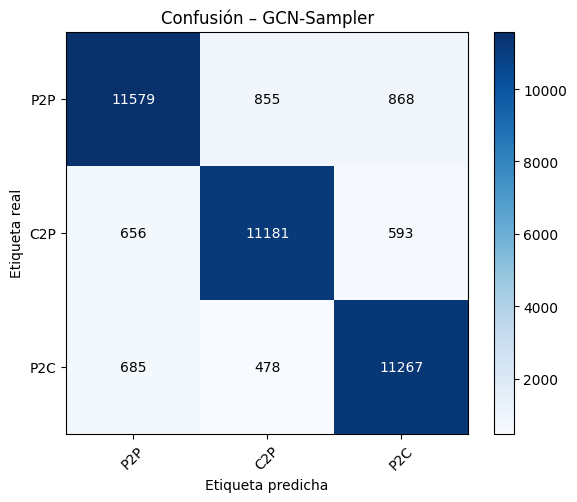

Matriz de confusión normalizada (%)


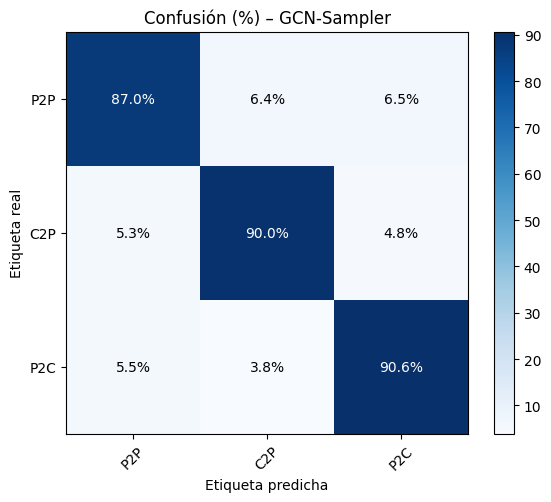

              precision    recall  f1-score   support

           0     0.8962    0.8705    0.8832     13302
           1     0.8935    0.8995    0.8965     12430
           2     0.8852    0.9064    0.8957     12430

    accuracy                         0.8916     38162
   macro avg     0.8916    0.8921    0.8918     38162
weighted avg     0.8917    0.8916    0.8916     38162



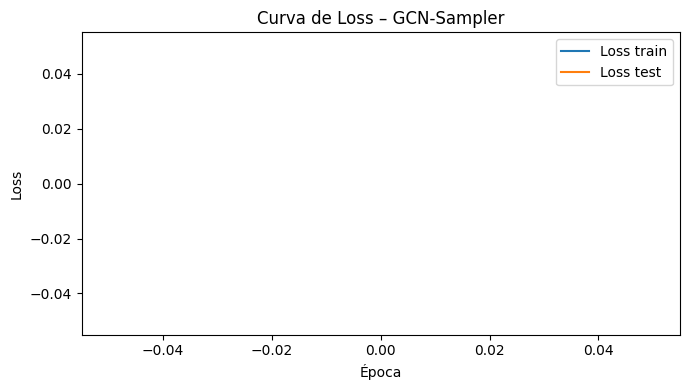

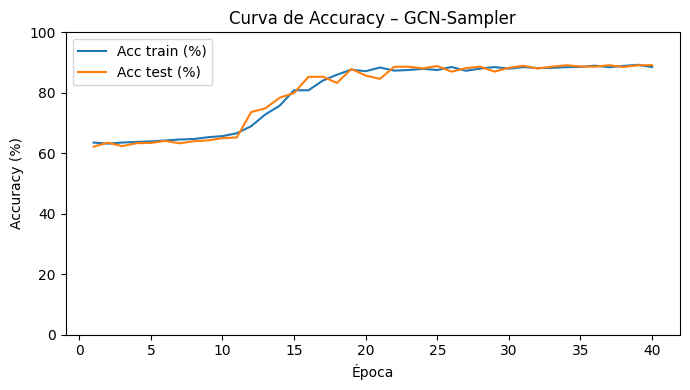


===== Entrenando SAGE-Sampler =====


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 61.64% | loss_te nan acc_te 62.34%


ep005 | loss_tr nan acc_tr 63.94% | loss_te nan acc_te 62.93%


ep010 | loss_tr nan acc_tr 66.37% | loss_te nan acc_te 66.99%


ep015 | loss_tr nan acc_tr 84.57% | loss_te nan acc_te 86.29%


ep020 | loss_tr nan acc_tr 86.57% | loss_te nan acc_te 85.17%


ep025 | loss_tr nan acc_tr 87.96% | loss_te nan acc_te 88.00%


ep030 | loss_tr nan acc_tr 87.61% | loss_te nan acc_te 88.09%


ep035 | loss_tr nan acc_tr 88.66% | loss_te nan acc_te 89.18%


🛑  Early-stop en época 40
Matriz de confusión sin normalizar


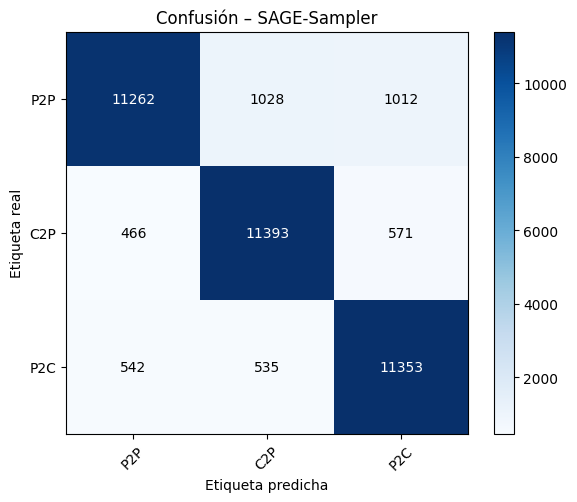

Matriz de confusión normalizada (%)


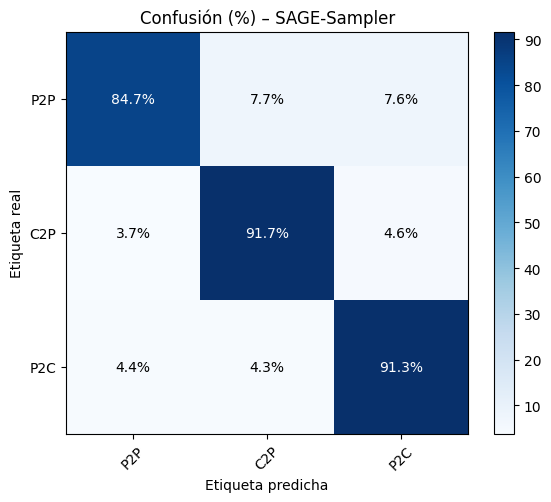

              precision    recall  f1-score   support

           0     0.9178    0.8466    0.8808     13302
           1     0.8794    0.9166    0.8976     12430
           2     0.8776    0.9134    0.8951     12430

    accuracy                         0.8911     38162
   macro avg     0.8916    0.8922    0.8912     38162
weighted avg     0.8922    0.8911    0.8909     38162



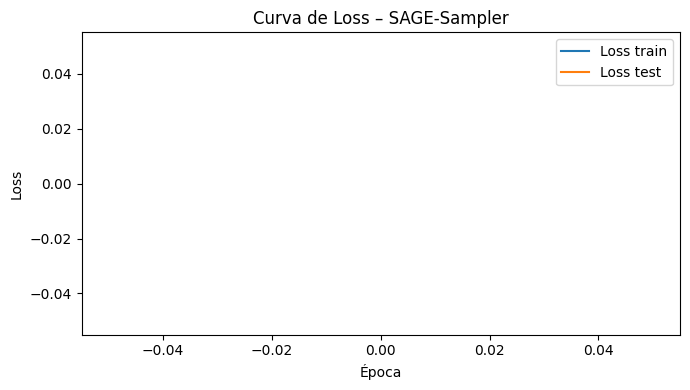

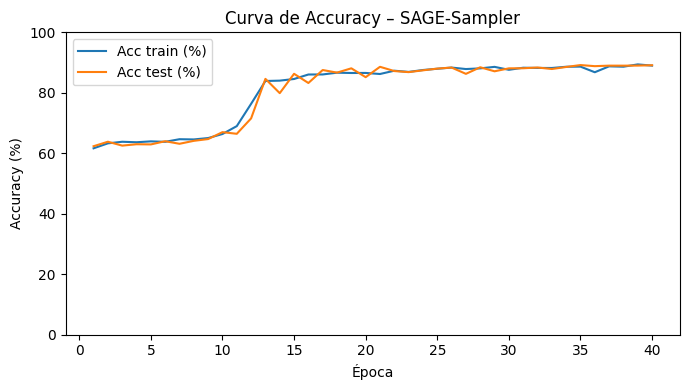


===== Entrenando GAT-Sampler =====


Epoch 001:   0%|          | 0/1000 [00:00<?, ?it/s]/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


ep001 | loss_tr nan acc_tr 45.61% | loss_te nan acc_te 49.14%


ep005 | loss_tr nan acc_tr 50.65% | loss_te nan acc_te 50.26%


ep010 | loss_tr nan acc_tr 73.99% | loss_te nan acc_te 71.04%


ep015 | loss_tr nan acc_tr 75.73% | loss_te nan acc_te 76.62%


ep020 | loss_tr nan acc_tr 76.11% | loss_te nan acc_te 77.43%


ep025 | loss_tr nan acc_tr 77.62% | loss_te nan acc_te 76.67%


ep030 | loss_tr nan acc_tr 77.80% | loss_te nan acc_te 78.15%


ep035 | loss_tr nan acc_tr 77.34% | loss_te nan acc_te 78.28%


🛑  Early-stop en época 40
Matriz de confusión sin normalizar


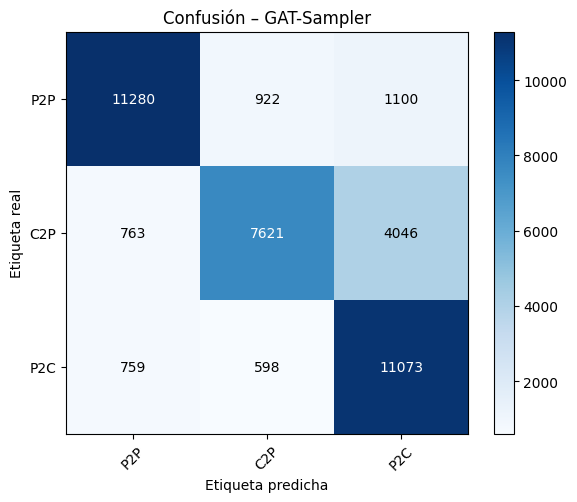

Matriz de confusión normalizada (%)


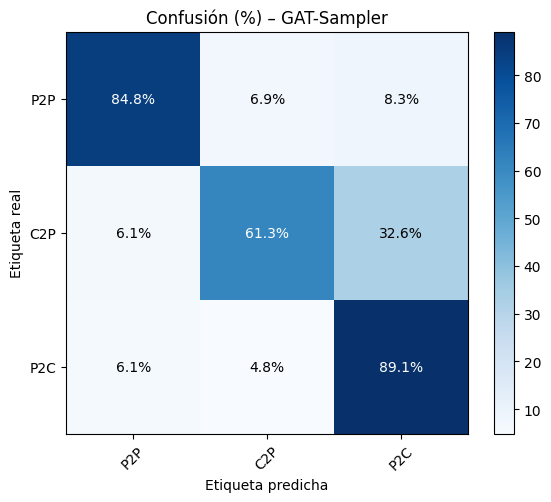

              precision    recall  f1-score   support

           0     0.8811    0.8480    0.8642     13302
           1     0.8337    0.6131    0.7066     12430
           2     0.6827    0.8908    0.7730     12430

    accuracy                         0.7854     38162
   macro avg     0.7992    0.7840    0.7813     38162
weighted avg     0.8011    0.7854    0.7832     38162



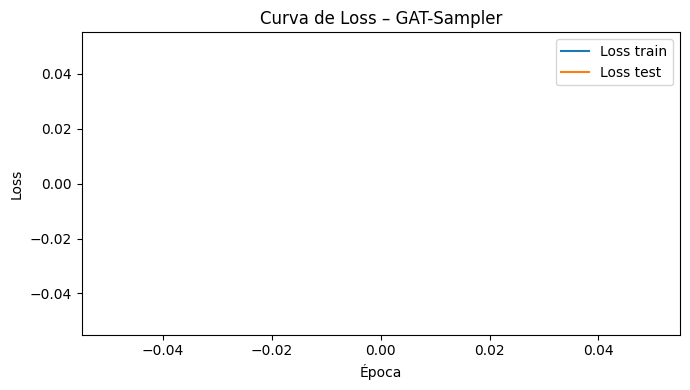

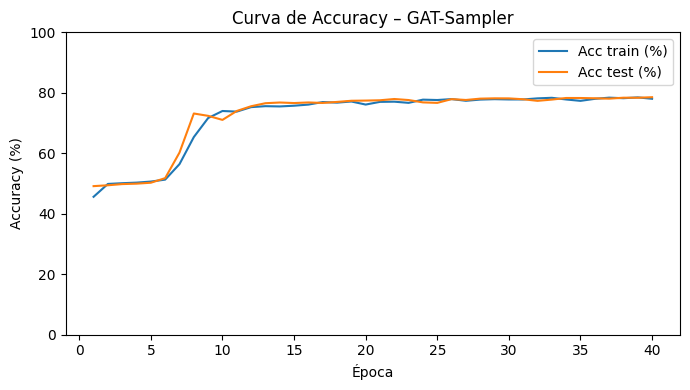

In [13]:
from tqdm.auto import tqdm
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ─── hiper-parámetros ──────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata['feat'].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 50
lr        = 1e-3
patience  = 40               # early-stopping
n_classes = 3

# ─── loop sobre modelos ────────────────────────────────────────────
for name, Model in models.items():
    print(f"\n===== Entrenando {name} =====")

    model = Model(in_feats, 64, 32, out_feats_mlp=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # historial
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, best_state, wait = 1e9, None, 0

    for epoch in range(1, epochs + 1):

        # ── TRAIN ───────────────────────────────────────────────────
        model.train()
        loss_sum = corr = tot = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}", leave=False)
        for subg in pbar:                    # subg = grafo de un cluster
            if subg.num_edges() == 0:
                continue 
            subg = subg.to(device)
            x    = subg.ndata['feat'].float()
            y    = subg.edata['Relationship'].long()
            m    = subg.edata['train_mask'].bool()

            h      = model.encode(subg, x)          # <- nota: grafo completo
            logits = model.decodeMLP(subg, h)       # (E_cluster, 3)

            loss = F.cross_entropy(logits[m], y[m])

            optim.zero_grad()
            loss.backward()
            optim.step()

            # métrica batch
            loss_sum += loss.item() * m.sum().item()
            pred      = logits[m].argmax(1)
            corr     += (pred == y[m]).sum().item()
            tot      += m.sum().item()

        loss_tr = loss_sum / tot
        acc_tr  = 100 * corr / tot

        # ── TEST ────────────────────────────────────────────────────
        model.eval()
        loss_sum = corr = tot = 0
        preds_all, truth_all = [], []

        with torch.no_grad():
            for subg in test_loader:
                subg = subg.to(device)
                x    = subg.ndata['feat'].float()
                y    = subg.edata['Relationship'].long()
                m    = subg.edata['test_mask'].bool()

                h      = model.encode(subg, x)
                logits = model.decodeMLP(subg, h)

                loss_sum += F.cross_entropy(logits[m], y[m]).item() * m.sum().item()
                pred      = logits[m].argmax(1)

                corr += (pred == y[m]).sum().item()
                tot  += m.sum().item()
                preds_all.append(pred.cpu())
                truth_all.append(y[m].cpu())

        loss_te = loss_sum / tot
        acc_te  = 100 * corr / tot

        # ── historial + early-stopping ─────────────────────────────
        hist['loss_tr'].append(loss_tr);  hist['loss_te'].append(loss_te)
        hist['acc_tr'].append(acc_tr);    hist['acc_te'].append(acc_te)

        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {epoch}")
                break

        if epoch % 5 == 0 or epoch == 1:
            print(f"ep{epoch:03d} | "
                  f"loss_tr {loss_tr:.4f} acc_tr {acc_tr:.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:.2f}%")

    # ─── evaluación final ──────────────────────────────────────────
    if best_state is None:                      # por si nunca mejoró
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    preds = torch.cat(preds_all)
    truth = torch.cat(truth_all)

    cm = confusion_matrix(truth, preds)
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=False, title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P", "C2P", "P2C"],
                            normalize=True,  title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds, digits=4))

    # ─── gráficos de historial ─────────────────────────────────────
    ep_axis = range(1, len(hist['loss_tr']) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['loss_tr'], label="Loss train")
    plt.plot(ep_axis, hist['loss_te'], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss")
    plt.title(f"Curva de Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(ep_axis, hist['acc_tr'], label="Acc train (%)")
    plt.plot(ep_axis, hist['acc_te'], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Curva de Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()


In [27]:
from collections import Counter
tot = Counter(); tr = Counter(); te = Counter()

for sg in train_loader:             # lo que ve el encoder
    y = sg.edata['Relationship'][ sg.edata['train_mask'] ].tolist()
    tr.update(y)
for sg in test_loader:
    y = sg.edata['Relationship'][ sg.edata['test_mask'] ].tolist()
    te.update(y)

tot.update( gnn.dgl_graph.edata['Relationship'].tolist() )

print("GLOBAL :", tot)
print("TRAIN  :", tr)
print("TEST   :", te)


/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


GLOBAL : Counter({-1: 699046, 0: 668732, 2: 154411, 1: 154411})
TRAIN  : Counter({0: 32702, 1: 31636, 2: 31636})
TEST   : Counter({0: 33258, 2: 31417, 1: 31417})


### Caso 4: Se utiliza grafo con atributos de nodos generados aleatoriamente

In [ ]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [ ]:
print("Total aristas:", gnn.dgl_graph.num_edges())
print("Training set:", train_m.sum().item())
print("Test set:", test_m.sum().item())
print("Intersección:", (train_m & test_m).sum().item())  # Debe ser 0

In [ ]:
RELATIONSHIPS_FILE = '/home/valentina/Desktop/GIT/TrabajoTesis/data/CAIDA_AS_Relationships/Serial_1/20240201.as-rel.txt.bz2'
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGraphs2024/febrero'

gnn = GNN(debug=True)

# Cargo dataset y etiqueto sgun archivo de relaciones
gnn.load_dataset(
    data_path=INTERNETGRAPH_FILE,  # Grafo internet no etiquetado
    force_reload=True,
    index_graph = 1,  # Indice del grafo a cargar febrero
    simplify=True,            # ⇐ hazlo sólo una vez
    caida_path=RELATIONSHIPS_FILE  # Archivo CAIDA AS Relationships
)


# 64 features con poca varianza inicial
# gnn.add_random_features(dim=64, std=0.05, seed=42, mode="minmax")

# gnn.add_random_features(dim=64, std=0.05, seed=42, mode="zscore")

gnn.add_random_features(dim=64, std=0.05, seed=42, mode="uniform")


# crea máscaras + devuelve eids
train_eids, test_eids = gnn.split_edges_classification(0.8, seed=42, return_eids=True)

In [ ]:
from torch import tensor

# contar la cantidad de ocurrencias por clase en las etiquetas de entrenamiento
train_labels = labels[train_m]
counts = torch.bincount(train_labels, minlength=n_classes)

# peso inverso a la frecuencia (opcionalmente se puede normalizar)
class_weights = 1.0 / counts.float()
class_weights = class_weights / class_weights.sum() * n_classes  # opcional: normalizar

class_weights = class_weights.to(device)



In [ ]:
import torch, torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ─── parámetros globales ────────────────────────────────────────────
in_feats  = gnn.dgl_graph.ndata["feat"].shape[1]
device    = "cuda" if torch.cuda.is_available() else "cpu"
epochs    = 200
lr        = 0.01
patience  = 10           # early-stopping
n_classes = 3

# ─── datos y máscaras ───────────────────────────────────────────────
g       = gnn.dgl_graph.to(device)
feat    = g.ndata["feat"].to(device)
labels  = g.edata["Relationship"].long().to(device)
train_m = g.edata["train_mask"].to(device)
test_m  = g.edata["test_mask"].to(device)

for name, Model in models.items():
    print(f"\n=== Training {name} ===")

    model = Model(in_feats, 32, 16, out_feats_mlp=n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters() , lr=lr)

    # histórico por modelo
    hist = {"loss_tr": [], "acc_tr": [], "loss_te": [], "acc_te": []}
    best_loss, wait = 1e9, 0

    for ep in range(1, epochs + 1):
        # ---------- train ----------
        model.train()
        h      = model.encode(g, feat)
        logits = model.decodeMLP(g, h)                  # (E, 3)

        loss   = F.cross_entropy(logits[train_m], labels[train_m])
        # loss   = F.cross_entropy(logits[train_m], labels[train_m], weight=class_weights)

        
        opt.zero_grad() 
        loss.backward()
        opt.step()

        with torch.no_grad():
            preds_tr = logits[train_m].argmax(1)
            acc_tr   = (preds_tr == labels[train_m]).float().mean().item()

        # ---------- test ----------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, feat))
            loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m])
            # loss_te  = F.cross_entropy(logits_t[test_m], labels[test_m], weight=class_weights)
            preds_t  = logits_t[test_m].argmax(1)
            acc_t    = (preds_t == labels[test_m]).float().mean().item()

        # guarda histórico
        hist["loss_tr"].append(loss.item())
        hist["acc_tr"].append(acc_tr * 100)
        hist["loss_te"].append(loss_te.item())
        hist["acc_te"].append(acc_t * 100)

        # early-stopping
        if loss_te < best_loss - 1e-4:
            best_loss, wait = loss_te, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early stop en época {ep}")
                break

        if ep % 10 == 0 or ep == 1:
            print(f"ep{ep:02d} | loss_tr {loss:.4f} acc_tr {acc_tr:.2%} | "
                  f"loss_te {loss_te:.4f} acc_te {acc_t:.2%}")

    # ---------- evaluación final ----------
    model.load_state_dict(best_w)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, feat))
        preds_best  = logits_best[test_m].argmax(1).cpu()
        truth       = labels[test_m].cpu()

    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")

    print(classification_report(truth, preds_best, digits=4))

    # ---------- curvas de entrenamiento ----------
    epochs_done = range(1, len(hist["loss_tr"]) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["loss_tr"], label="Loss train")
    plt.plot(epochs_done, hist["loss_te"], label="Loss test")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.title(f"Loss – {name}")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs_done, hist["acc_tr"], label="Acc train (%)")
    plt.plot(epochs_done, hist["acc_te"], label="Acc test (%)")
    plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.ylim(0,100)
    plt.title(f"Accuracy – {name}")
    plt.legend(); plt.tight_layout(); plt.show()




Posibles arreglos: Diferencia de arquitectura.

GCN usa la matriz de adyacencia simétrica → capta información global
rápidamente aun con features aleatorios.

GraphSAGE (mean) y GAT agregan solamente vecinos; al inicio todos
los nodos tienen casi el mismo vector aleatorio normalizado
⇒ el primer paso de agregación produce embeddings muy parecidos en todas
partes ⇒ el gradiente se vuelve más pequeño que en GCN y cuesta salir del
mínimo “todo-P2P”.

Falta de self-loop en SAGE y GAT. Al no sumar la propia característica el “mensaje” inicial puede diluirse aún más. (GCN lo incorpora por defecto en tu código).

Función de pérdida sin ponderar. F.cross_entropy default = ponderación uniforme → la clase mayoritaria domina.


In [ ]:
# version arreglada por chatgpt

import torch, torch.nn.functional as F
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# ─── configuración general ─────────────────────────────────────────
device   = "cuda" if torch.cuda.is_available() else "cpu"
g        = gnn.dgl_graph
g = dgl.add_self_loop(g)
g = g.to(device)

x        = g.ndata['feat'].to(device)
y        = g.edata['Relationship'].long().to(device)
tr, te   = g.edata['train_mask'], g.edata['test_mask']

# pesos inversos al nº de ejemplos por clase (0,1,2)
cnt      = Counter(y[tr].tolist())
w_cls    = torch.tensor([1/cnt[i] for i in range(3)], device=device, dtype=torch.float)

epochs   = 120
lr       = 1e-3          # algo más bajo ayuda a SAGE/GAT
patience = 10

# ─── entrenamiento por cada arquitectura ───────────────────────────
for name, Model in models.items():          # GCN, GraphSAGE, GAT …
    print(f"\n=== {name} ===")
    model = Model(x.shape[1], 64, 32, out_feats_mlp=3).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    hist  = {'ltr':[], 'lte':[], 'atr':[], 'ate':[]}
    best_loss, wait, best_w = 1e9, 0, None

    for ep in range(1, epochs + 1):
        # -------- train --------
        model.train()
        logits = model.decodeMLP(g, model.encode(g, x))
        loss   = F.cross_entropy(logits[tr], y[tr], weight=w_cls)

        opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            pred_tr = logits[tr].argmax(1)
            acc_tr  = (pred_tr == y[tr]).float().mean().item()*100

        # -------- test ---------
        model.eval()
        with torch.no_grad():
            logits_t = model.decodeMLP(g, model.encode(g, x))
            loss_te  = F.cross_entropy(logits_t[te], y[te], weight=w_cls)
            pred_te  = logits_t[te].argmax(1)
            acc_te   = (pred_te == y[te]).float().mean().item()*100

        # -------- histórico ----
        hist['ltr'].append(loss.item()) ; hist['lte'].append(loss_te.item())
        hist['atr'].append(acc_tr)       ; hist['ate'].append(acc_te)

        # -------- early-stop ----
        if loss_te < best_loss - 1e-4:
            best_loss, wait, best_w = loss_te, 0, {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                print(f"🛑  Early-stop en época {ep}")
                break

        if ep % 20 == 0 or ep == 1:
            print(f"ep{ep:03d} | loss_tr {loss:.4f} acc_tr {acc_tr:5.2f}% | "
                  f"loss_te {loss_te:.4f} acc_te {acc_te:5.2f}%")

    # ─── evaluación final ───────────────────────────────────────────
    model.load_state_dict(best_w, strict=False)
    with torch.no_grad():
        logits_best = model.decodeMLP(g, model.encode(g, x))
        preds_best  = logits_best[te].argmax(1).cpu()
        truth       = y[te].cpu()

    # matriz de confusión
    cm = confusion_matrix(truth, preds_best)
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], False,
                            title=f"Confusión – {name}")
    plot_confusion_matrix_2(cm, ["P2P","C2P","P2C"], True,
                            title=f"Confusión (%) – {name}")
    print(classification_report(truth, preds_best, digits=4))

    # curvas
    ep_axis = range(1, len(hist['ltr'])+1)
    plt.figure(figsize=(6.5,3))
    plt.plot(ep_axis, hist['ltr'], label='Loss train')
    plt.plot(ep_axis, hist['lte'], label='Loss test')
    plt.xlabel('Época'); plt.ylabel('Loss'); plt.title(f'Loss – {name}')
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6.5,3))
    plt.plot(ep_axis, hist['atr'], label='Acc train (%)')
    plt.plot(ep_axis, hist['ate'], label='Acc test (%)')
    plt.xlabel('Época'); plt.ylabel('Accuracy (%)'); plt.ylim(0,100)
    plt.title(f'Accuracy – {name}')
    plt.legend(); plt.tight_layout(); plt.show()
